In [1]:
import pandas as pd # importing necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler 
import warnings 
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('customers.xlsx') #importing the dataset

In [3]:
df.head() # Displays the first 5 rows and columns of the data set

,sifarisci,tarix,Satis (azn)
0,556227575,2019-05-18,15.0
1,557660657,2019-05-18,30.0
2,556724772,2019-05-18,23.0
3,505244006,2019-05-18,28.0
4,546450050,2019-05-18,26.0


In [4]:
df.rename(columns={'sifarisci':'id','tarix':'date','Satis (azn)':'cost($)'}, inplace = True) # renaming the columns of the dataset

In [5]:
df.head() 

,id,date,cost($)
0,556227575,2019-05-18,15.0
1,557660657,2019-05-18,30.0
2,556724772,2019-05-18,23.0
3,505244006,2019-05-18,28.0
4,546450050,2019-05-18,26.0


In [6]:
df.info() # Provides info about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       1990 non-null   object        
 1   date     1999 non-null   datetime64[ns]
 2   cost($)  1990 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.0+ KB


Data Cleaning

In [7]:
df.isnull() # Checks for any null value present in the dataset

,id,date,cost($)
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
1994,False,False,False
1995,False,False,False
1996,False,False,False
1997,False,False,False


In [8]:
df.dropna(inplace=True) # This will remove null values present in the dataset(in our case there were no null values present)

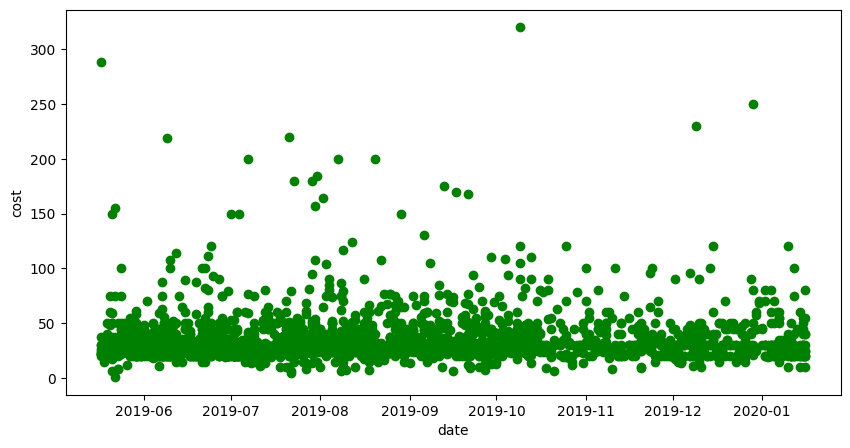

In [9]:
plt.figure(figsize = (10,5))
plt.scatter(df['date'],df['cost($)'], c = 'green')
plt.xlabel('date')
plt.ylabel('cost')
plt.show()

In [10]:
df.id.nunique()

1546

In [11]:
cst = pd.DataFrame(df['id'].unique(),columns = ['uid']).astype('str')
cst

,uid
0,556227575
1,557660657
2,556724772
3,505244006
4,546450050
...,...
1541,556402456
1542,555552227
1543,552007006
1544,552264462


On Recency

In [12]:
df_rcn=df.groupby('id')['date'].max().reset_index()
df_rcn['recency']=(df_rcn['date'].max() - df_rcn['date']).dt.days
df_rcn.drop(columns=['date'], inplace=True)
df_rcn

,id,recency
0,224,167
1,45002262,200
2,50407770,219
3,54272224,188
4,55252426,188
...,...,...
1541,0776262626,44
1542,0776262726,217
1543,0777656656,205
1544,Emin,240


On Frequency

In [13]:
df_frq = df.groupby('id')['date'].count().reset_index()
df_frq['frequency'] = df_frq['date']
df_frq.drop(columns=['date'],inplace = True)
df_frq

,id,frequency
0,224,2
1,45002262,1
2,50407770,1
3,54272224,1
4,55252426,1
...,...,...
1541,0776262626,1
1542,0776262726,1
1543,0777656656,1
1544,Emin,1


On Monetary : Usually, Monetary is accepted as the sum of all purchase(or other types of) values, but in this case,  it was considered and calculated as average.

In [14]:
df_rvn=df.groupby('id')['cost($)'].mean().reset_index() # on average sale(revenue) for each customer
df_rvn.rename(columns={'cost($)':'mean_rev'}, inplace=True)
df_rvn

,id,mean_rev
0,224,86.0
1,45002262,36.0
2,50407770,30.0
3,54272224,14.0
4,55252426,30.0
...,...,...
1541,0776262626,40.0
1542,0776262726,30.0
1543,0777656656,28.0
1544,Emin,6.0


In [15]:
# Merging datasets to RFM 
rfm=df_rcn.merge(df_frq, left_on='id', right_on='id').merge(df_rvn, left_on='id', right_on='id')
rfm.head()

,id,recency,frequency,mean_rev
0,224,167,2,86.0
1,45002262,200,1,36.0
2,50407770,219,1,30.0
3,54272224,188,1,14.0
4,55252426,188,1,30.0


Data Normalization(Scaling)


In [16]:
# Scaling
md_rfm=rfm[['recency','frequency','mean_rev']]
rb=RobustScaler()
rb.fit(md_rfm)
md_rfm=pd.DataFrame(rb.transform(md_rfm), columns=['recency','frequency','mean_rev'])
md_rfm['id']=rfm.id
md_rfm.head()

,recency,frequency,mean_rev,id
0,0.188119,1.0,3.500,224
1,0.514851,0.0,0.375,45002262
2,0.702970,0.0,0.000,50407770
3,0.396040,0.0,-1.000,54272224
4,0.396040,0.0,0.000,55252426


I aim to divide customers into four segmentation: Loyal customers, Can't lose them, Lost customers, New customers

Modelling

In [17]:
kms=KMeans(n_clusters=4)
kms.fit(md_rfm[['recency','frequency','mean_rev']])
clustered=pd.DataFrame(kms.predict(md_rfm[['recency','frequency','mean_rev']]), columns=['Segmented_group'])
clustered=clustered.merge(md_rfm, left_index=True, right_index=True)
clustered

,Segmented_group,recency,frequency,mean_rev,id
0,1,0.188119,1.0,3.500,224
1,0,0.514851,0.0,0.375,45002262
2,0,0.702970,0.0,0.000,50407770
3,0,0.396040,0.0,-1.000,54272224
4,0,0.396040,0.0,0.000,55252426
...,...,...,...,...,...
1541,1,-1.029703,0.0,0.625,0776262626
1542,0,0.683168,0.0,0.000,0776262726
1543,0,0.564356,0.0,-0.125,0777656656
1544,0,0.910891,0.0,-1.500,Emin


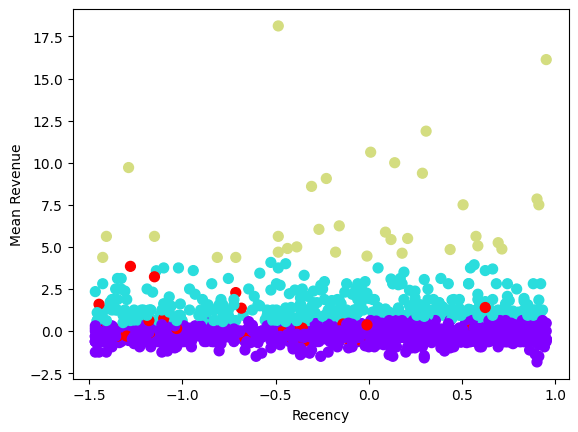

In [18]:
plt.scatter(clustered['recency'], clustered['mean_rev'], c=clustered['Segmented_group'], s=50, cmap='rainbow')
plt.xlabel('Recency')
plt.ylabel('Mean Revenue')
plt.show()

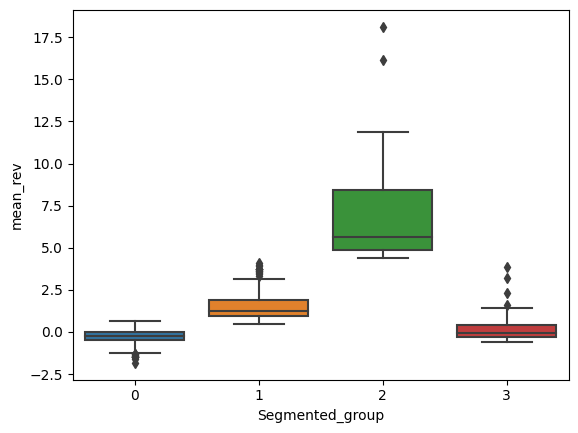

In [19]:
sns.boxplot( x ='Segmented_group', y ='mean_rev',data=clustered)
plt.show()

Can be seen, 3rd segmentation is a too wealthy group of customers, therefore "Can't lose them"

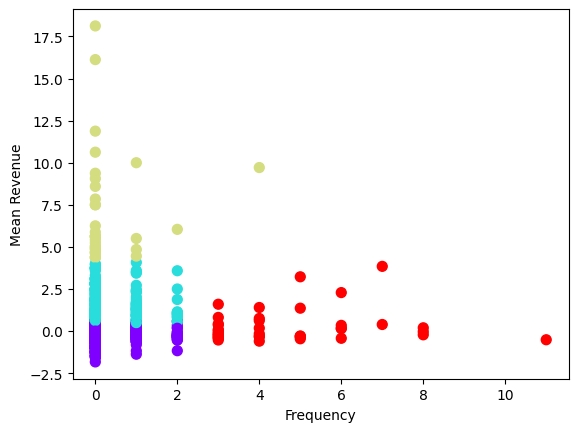

In [20]:
plt.scatter(clustered['frequency'], clustered['mean_rev'], c=clustered['Segmented_group'], s=50, cmap='rainbow')
plt.xlabel('Frequency')
plt.ylabel('Mean Revenue')
plt.show()

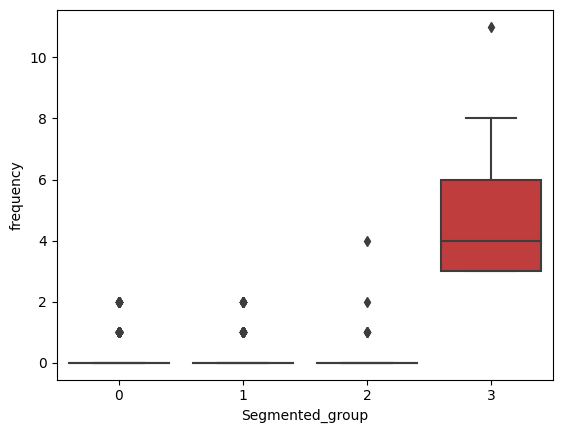

In [21]:
sns.boxplot(x='Segmented_group',y= 'frequency',data=clustered)
plt.show()

2nd segmentation holds those customers who most frequently do purchase, so that is "Loyal Customers"

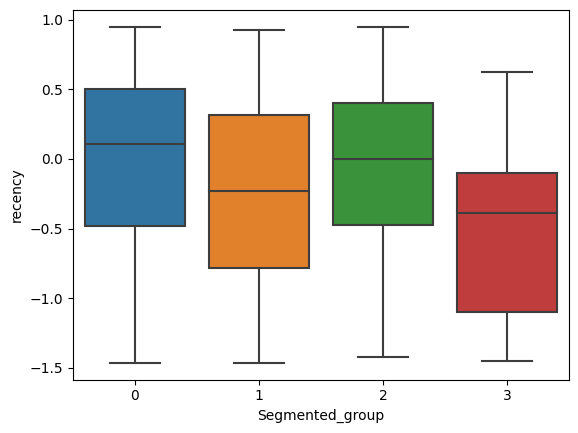

In [22]:
sns.boxplot(x='Segmented_group', y='recency',data=clustered)
plt.show()
#sns.boxenplot('Segmented_group','recency',data=clustured)

Less period means they purchases recently, hence 0 segmentation are "New Customers" and other(2) segmentation displays, "Lost Customers", unfortunately